**Problem Statement**

HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes.

 
After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid. 

 
Your job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.

In [1]:
import pandas as pd
import numpy as np
import sklearn

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
#importing data
df = pd.read_csv('../input/country-data-test-2020/Country-data.csv')

In [3]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
df.shape

(167, 10)

## Cleaning the data

In [5]:
#We have no null values in the data
df.isnull().sum(axis=0)

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [6]:
#Check duplicate records in data
df.duplicated(subset=None, keep='first').sum()

0

In [7]:
#There are 3 columns: exports, health and imports which have been reported as percentage of GDPP.
#We will be convering these to absolute values.
df['health'] = round(df['health']*df['gdpp']/100,2)
df['exports'] = round(df['exports']*df['gdpp']/100,2)
df['imports'] = round(df['imports']*df['gdpp']/100,2)
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200


## Performing Exploratory Data Analysis

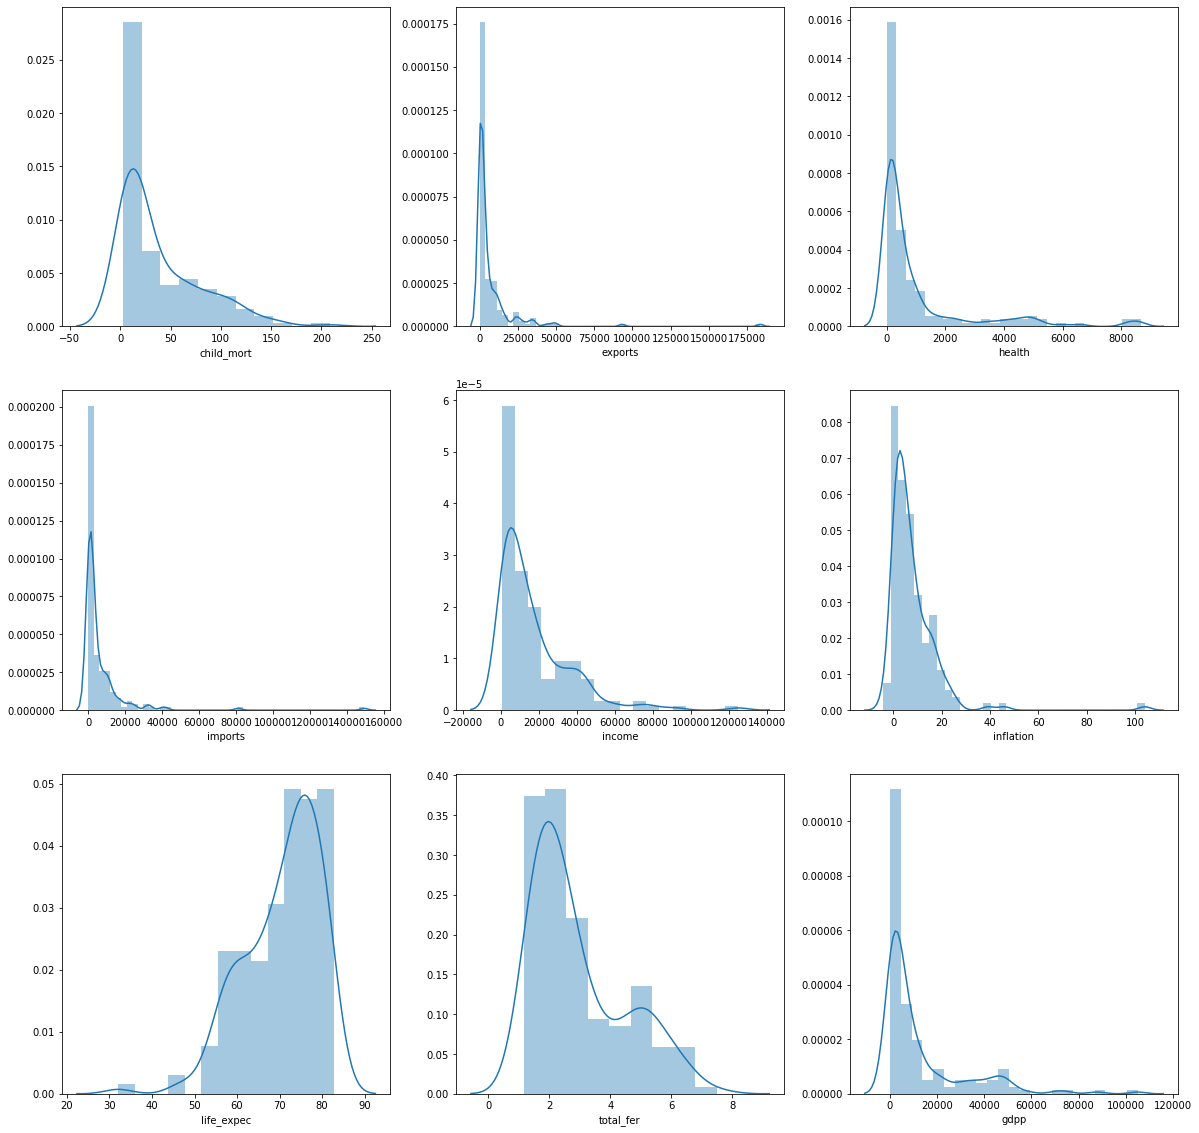

In [8]:
#Let's see the distribution of all the variables available in the dataset
plt.figure(figsize=(20,20))
for i,col in enumerate (list(df.drop(['country'],axis=1).columns)):
    plt.subplot(3,3,i+1)
    sns.distplot(df[col])
plt.show()

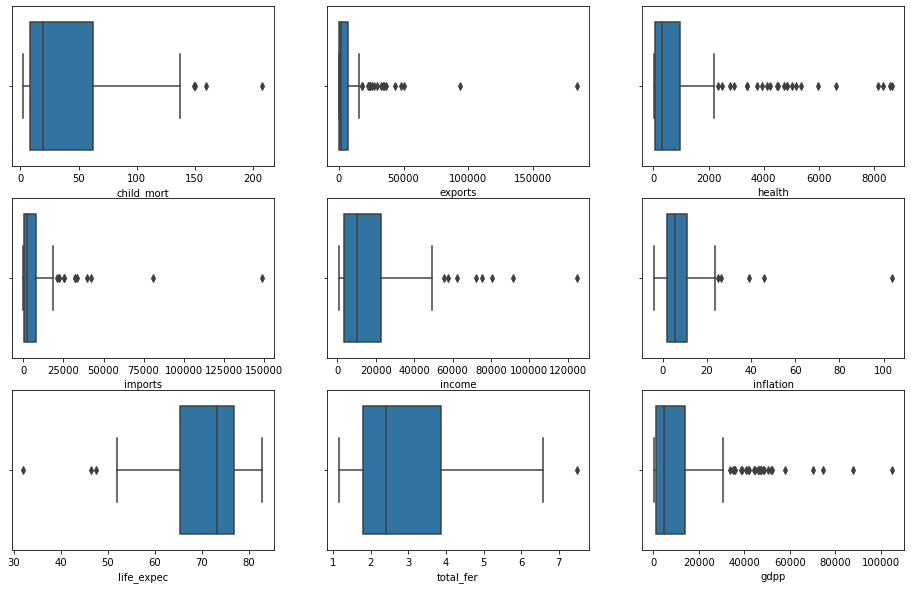

In [9]:
#Visualizing variables using box plots. This will also help us identify outliers.
plt.figure(figsize=(16,10))
for i,col in enumerate (list(df.drop(['country'],axis=1).columns)):
    plt.subplot(3,3,i+1)
    sns.boxplot(df[col])
plt.show()

We can spot some outliers in the data now in all the columns. When we treat these outliers, we will need to keep in mind the business objective so that valuable information does not get capped or lost.

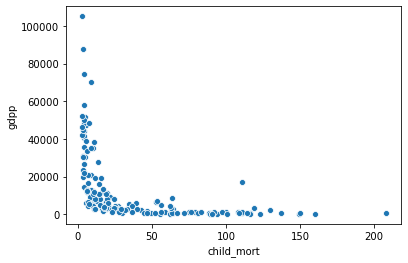

In [10]:
#In this scatter, we can see a strong correlation between GDP per capita and child mortality rates
sns.scatterplot(x='child_mort', y='gdpp',data=df)

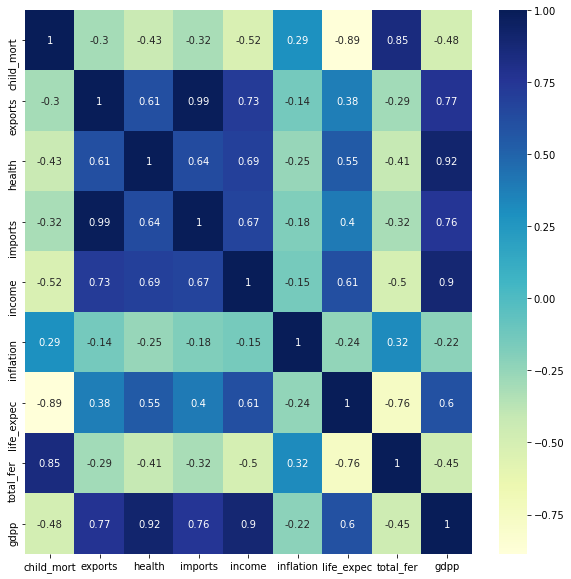

In [11]:
#Let's visualize correlations between different variables
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap='YlGnBu')

We can make several observations here. 
* All the factors that would be impacted by the financial strenght of a country show a strong positive correlation with the GDPP.
* Child mortality and Total Fertility are seen to be decreasing as the GDPP increases. 
* Total fertility and child mortality have a strong positive correlation, indicating counntries with a high fertility rate also have much higher child mortality rates. 
* In summary, income and GDP seem to be playing a major role in determining the socio economic well being of a country, and most importantly, the child mortaliy and life expectancy rates. 

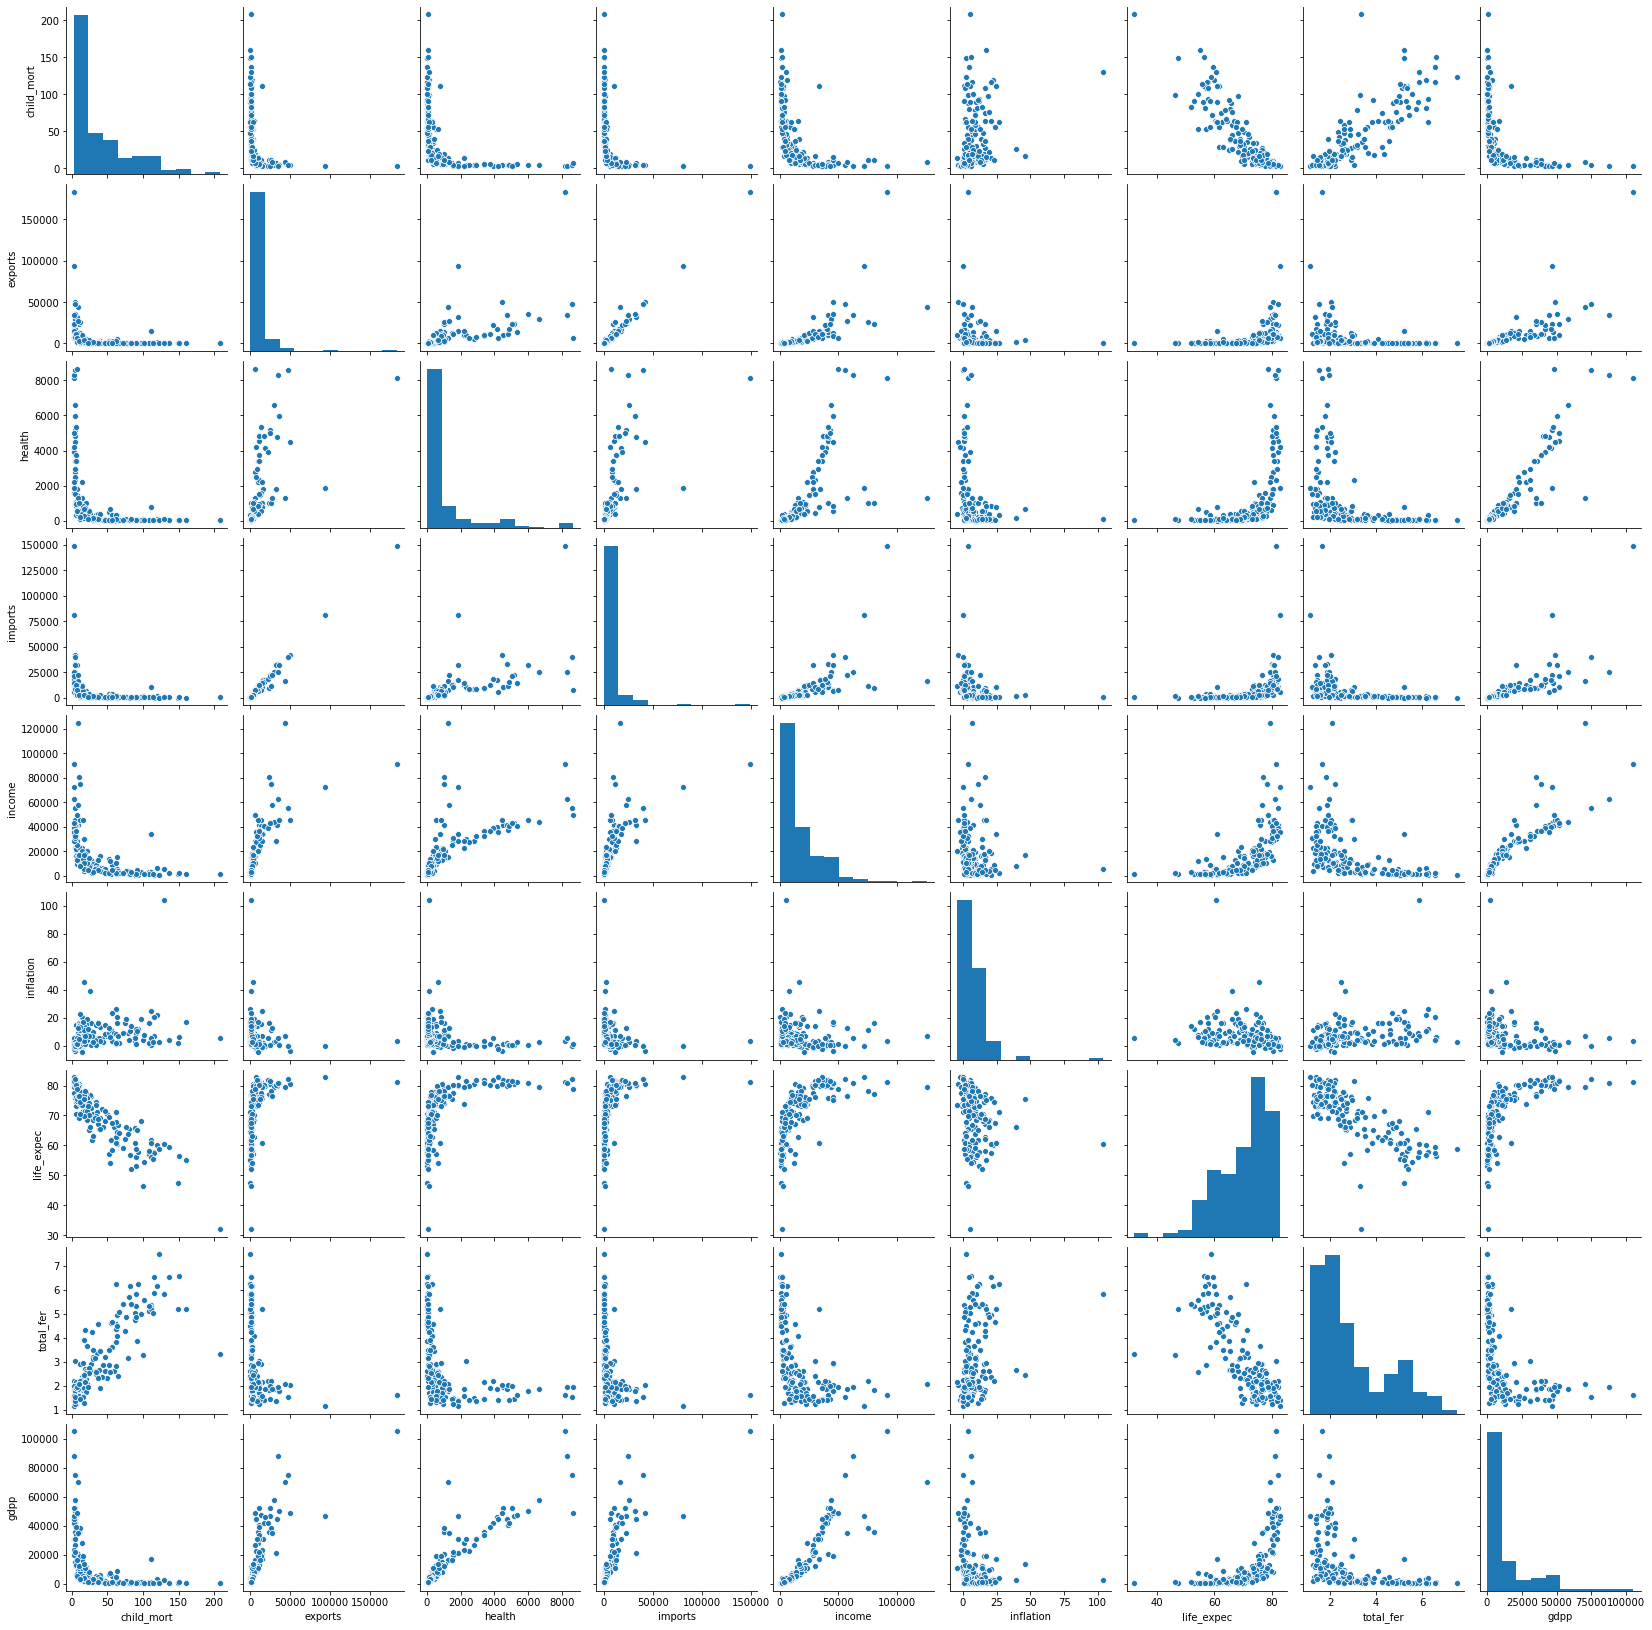

In [12]:
#To get a better understanding of how all variables are related to one another, we can also use a pair plot.
sns.pairplot(df)

## Outlier treatment
We need to treat the outliers in the data. However, as pointed out earlier we would need to be careful in our approach keeping in mind that we must not lose information valudable to the business objective in this process. 
* Since the size of the data set is not huge and every country needs representation in the final result, we must not drop the rows that contain the outliers. 
* A good approach to follow here would be capping. We can perform capping on a soft range (retaining values between the 1st and 99th percentile.
    * We will not be capping any outliers in the lower range for all columns except child mortality. This is because since the business objective is to identify countries with immediate need of help we must retain the low values in data to make sure these countries get the weightage they deserve in our model. 
    * We will be applying a cap on the lower end of child mortality since a high child mortality could end up being an extremely important parameter in determining which countries require support. 

In [13]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618862,1056.733174,6588.352096,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885789,1801.408921,14710.810423,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.080000,12.820000,0.650000,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535000,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.890000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [14]:
for each in list(df.drop(['child_mort','country'],axis=1).columns):
    df[each][df[each]>=df[each].quantile(0.99)] = df[each].quantile(0.99)
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,6538.214790,1054.206592,5873.135210,16857.550898,7.380970,70.551138,2.942259,12756.826347
std,40.328931,11415.308582,1790.845357,9422.700877,17957.012855,7.793224,8.886987,1.498340,17430.208938
min,2.600000,1.080000,12.820000,0.650000,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535000,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.890000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,64794.260000,8410.330400,55371.390000,84374.000000,41.478000,82.370000,6.563600,79088.000000


In [15]:
df['child_mort'][df['child_mort']<=df['child_mort'].quantile(0.01)] = df['child_mort'].quantile(0.01)
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.271257,6538.214790,1054.206592,5873.135210,16857.550898,7.380970,70.551138,2.942259,12756.826347
std,40.327869,11415.308582,1790.845357,9422.700877,17957.012855,7.793224,8.886987,1.498340,17430.208938
min,2.800000,1.080000,12.820000,0.650000,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535000,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.890000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,64794.260000,8410.330400,55371.390000,84374.000000,41.478000,82.370000,6.563600,79088.000000


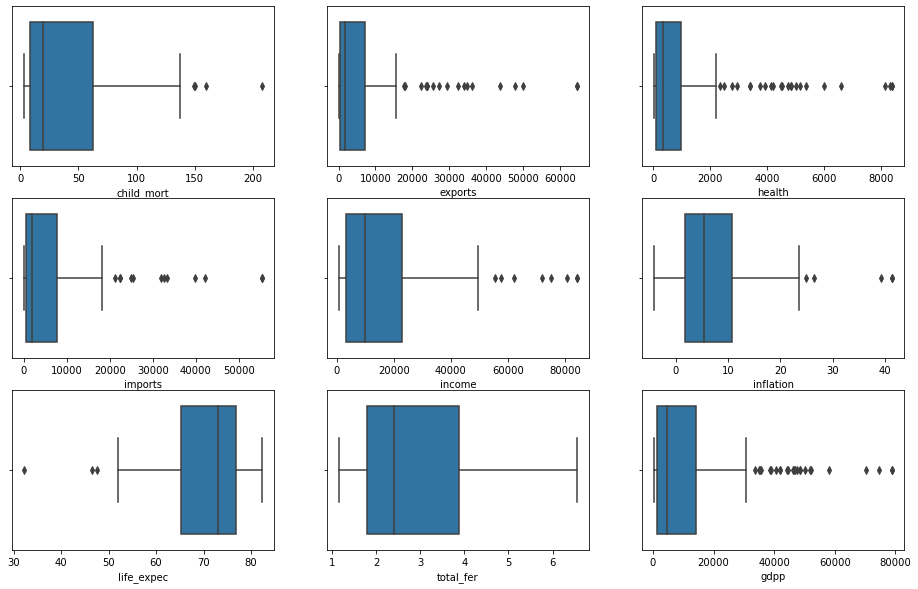

In [16]:
#Visualizing variables using box plots. This will also help us identify outliers again.
plt.figure(figsize=(16,10))
for i,col in enumerate (list(df.drop(['country'],axis=1).columns)):
    plt.subplot(3,3,i+1)
    sns.boxplot(df[col])
plt.show()

We are still seeing a significant number of outliers in the financial variables like gdpp, income, imports, exports, health. Let's further cap these down to 90th percentile on the upper end. 

In [17]:
for each in ['gdpp','imports','exports','income','health']:
    df[each][df[each]>=df[each].quantile(0.90)] = df[each].quantile(0.90)
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.271257,4735.951198,861.783784,4458.383593,15216.185629,7.380970,70.551138,2.942259,11444.874251
std,40.327869,5888.387123,1214.790311,5018.135698,13724.389598,7.793224,8.886987,1.498340,13884.690796
min,2.800000,1.080000,12.820000,0.650000,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535000,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.890000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,17760.600000,3825.416000,15034.280000,41220.000000,41.478000,82.370000,6.563600,41840.000000


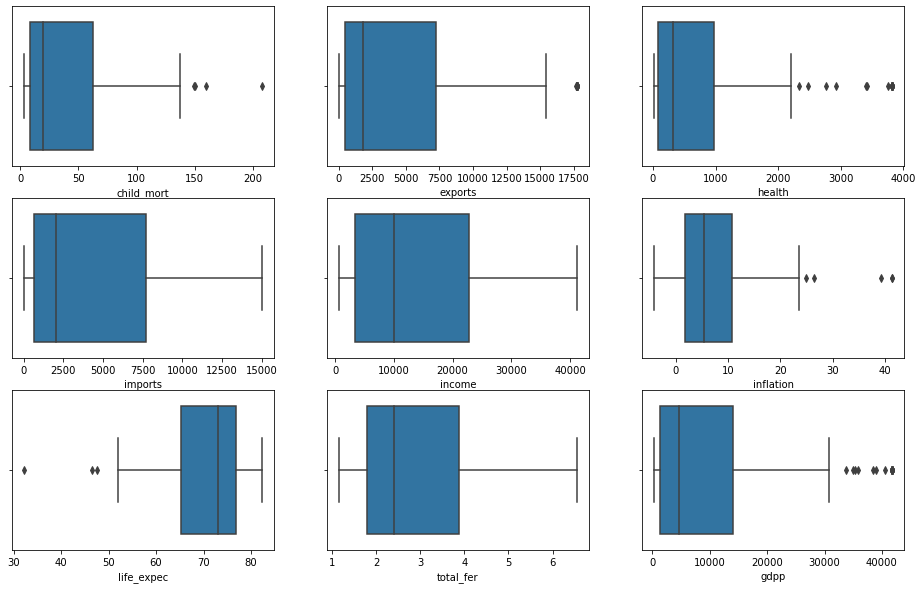

In [18]:
#Visualizing variables using box plots. This will also help us identify outliers again.
plt.figure(figsize=(16,10))
for i,col in enumerate (list(df.drop(['country'],axis=1).columns)):
    plt.subplot(3,3,i+1)
    sns.boxplot(df[col])
plt.show()

* Our variables now seem to be in an adequate range relatively free of major outliers that could have heavily impacted the clustering process.
* We will move forward to model building now.

## Hopkins Score

In [19]:
#Function to calculate hopkins score
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
from statistics import median, mean
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [20]:
#Since hopkins score can vary due to the randomness of the sample chosen, we will take 20 samples and look at the mean and median. 
h_scores = []
for i in range(20):
    h_scores.append(round(hopkins(df.drop('country', axis = 1)),2))
print(h_scores)
print('Median of 20 samples: ',median(h_scores))
print('Mean of 20 samples: ',mean(h_scores))


[0.85, 0.92, 0.89, 0.84, 0.9, 0.9, 0.87, 0.89, 0.88, 0.9, 0.92, 0.85, 0.89, 0.85, 0.88, 0.87, 0.89, 0.84, 0.88, 0.91]
Median of 20 samples:  0.885
Mean of 20 samples:  0.881


We get a fairly good value of the Hopkins statistic indicating that our dataset is not completely randomly distributed and there are some inherent clusters present in the data. 
We can proceed with building our model further.

## Scaling of features
We will be using the standard scaler provided by sklearn for this purpose. 

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df1 = scaler.fit_transform(df.drop('country', axis = 1))
df1 = pd.DataFrame(df1, columns = df.drop(['country'],axis=1).columns)
df1.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291537,-0.797286,-0.676931,-0.841497,-0.994369,0.265002,-1.619705,1.926396,-0.786811
1,-0.538993,-0.611636,-0.490348,-0.493824,-0.386326,-0.372075,0.648831,-0.865054,-0.531304
2,-0.272870,-0.514980,-0.557986,-0.611211,-0.169272,1.122161,0.671403,-0.034983,-0.504576
3,2.007831,-0.432103,-0.628481,-0.588439,-0.680847,1.932987,-1.179541,2.153997,-0.571758
4,-0.695682,0.138833,-0.104136,0.545147,0.283837,-0.764618,0.705262,-0.543736,0.054549


In [22]:
df1.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02
mean,-7.977650e-18,1.662011e-17,-6.648042e-18,3.324021e-18,4.587149e-17,-2.592736e-17,3.722904e-17,1.223240e-16,5.118992e-17
std,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00
min,-8.822172e-01,-8.065216e-01,-7.009581e-01,-8.909963e-01,-1.067524e+00,-1.491787e+00,-4.339691e+00,-1.199761e+00,-8.100721e-01
25%,-7.466684e-01,-7.305413e-01,-6.466996e-01,-7.631623e-01,-8.668406e-01,-7.169978e-01,-5.926565e-01,-7.679895e-01,-7.306821e-01
50%,-4.718403e-01,-5.039426e-01,-4.457704e-01,-4.822628e-01,-3.841332e-01,-2.562428e-01,2.876710e-01,-3.563007e-01,-4.901283e-01
75%,5.926524e-01,4.330038e-01,9.508024e-02,6.518406e-01,5.542413e-01,4.336026e-01,7.052622e-01,6.277359e-01,1.881901e-01
max,4.221379e+00,2.218574e+00,2.446962e+00,2.113873e+00,1.900414e+00,4.388373e+00,1.333906e+00,2.424172e+00,2.195695e+00


We now have the data frame df1 which has all the numerical variables scaled down using standard scaler.

## K-Means Clustering

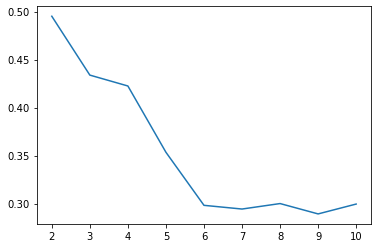

In [23]:
# We first need to determine the valye of K. There are two methods for this - 
# Silhouette score
# Elbow curve (SSD)

#First, we will be looking at silhouette score metric

from sklearn.metrics import silhouette_score
ss = []
for k in range(2, 11):
    kmean = KMeans(n_clusters = k).fit(df1)
    ss.append([k, silhouette_score(df1, kmean.labels_)])
temp = pd.DataFrame(ss)    
plt.plot(temp[0], temp[1])

We can observe that the average silhouette score sees a dip on going from 2 to 3, and then a very big dip on going from 4 to 5. From here, we may pick 3 as our value of k. This can be further confirmed by looking at the elbow curve below

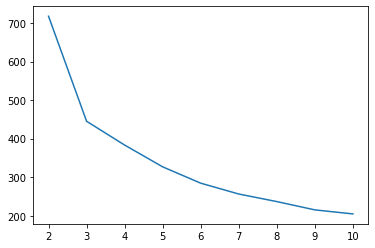

In [24]:
#Let's look at the elbow curve now
ssd = []
for k in range(2, 11):
    kmean = KMeans(n_clusters = k).fit(df1)
    ssd.append([k, kmean.inertia_])
    
temp = pd.DataFrame(ssd)
plt.plot(temp[0], temp[1])

The elbow curve seems to bend at around k=3. Hence, we can proceed 3 as our final number of clusters.

In [25]:
# Selecting K=3
# Final Kmean Clustering

kmean = KMeans(n_clusters = 3, random_state = 1) #fixing random state so the cluster IDs do not change
kmean.fit(df1)

KMeans(n_clusters=3, random_state=1)

In [26]:
#Let's make a copy of the original dataframe to add the cluster labels.
df_km = df.copy()

In [27]:
#We'll name the new column as 'labels'
label = pd.DataFrame(kmean.labels_, columns = ['label'])
label.head()

,label
0,2
1,0
2,0
3,2
4,0


In [28]:
#Next, we append this column to the original data frame copy.
df_km = pd.concat([df_km, label], axis =1)
df_km.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
0,Afghanistan,90.2,55.30,41.92,248.30,1610.0,9.44,56.2,5.82,553.0,2
1,Albania,16.6,1145.20,267.90,1987.74,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.98,1400.44,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.60,1514.37,5900.0,22.40,60.1,6.16,3530.0,2
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100.0,1.44,76.8,2.13,12200.0,0


In [29]:
#We'll run another iteration of K-means with value of K set to 4, using similar process as we did for k=3
kmean4 = KMeans(n_clusters = 4, random_state = 1) #fixing random state so the cluster IDs do not change
kmean4.fit(df1)
df_km4 = df.copy()
label = pd.DataFrame(kmean4.labels_, columns = ['label'])
df_km4 = pd.concat([df_km4, label], axis =1)
df_km4.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
0,Afghanistan,90.2,55.30,41.92,248.30,1610.0,9.44,56.2,5.82,553.0,2
1,Albania,16.6,1145.20,267.90,1987.74,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.98,1400.44,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.60,1514.37,5900.0,22.40,60.1,6.16,3530.0,3
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100.0,1.44,76.8,2.13,12200.0,0


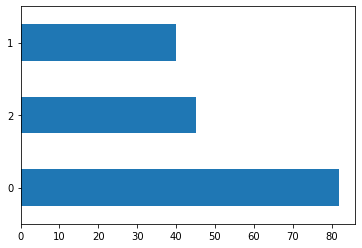

In [30]:
#Let's see how the labels are spread out now. 
df_km.label.value_counts().plot.barh()

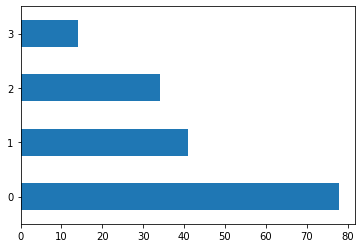

In [31]:
#Let's also see the spread for k=4
df_km4.label.value_counts().plot.barh()

## Cluster profiling from the model built using k-means

We will be using the features gdpp, child_mort and income for performing cluster performing cluster profiling. 
This is because as per business understanding and objective, these would be the major deciding factors and they also showed a good spread when performing EDA.

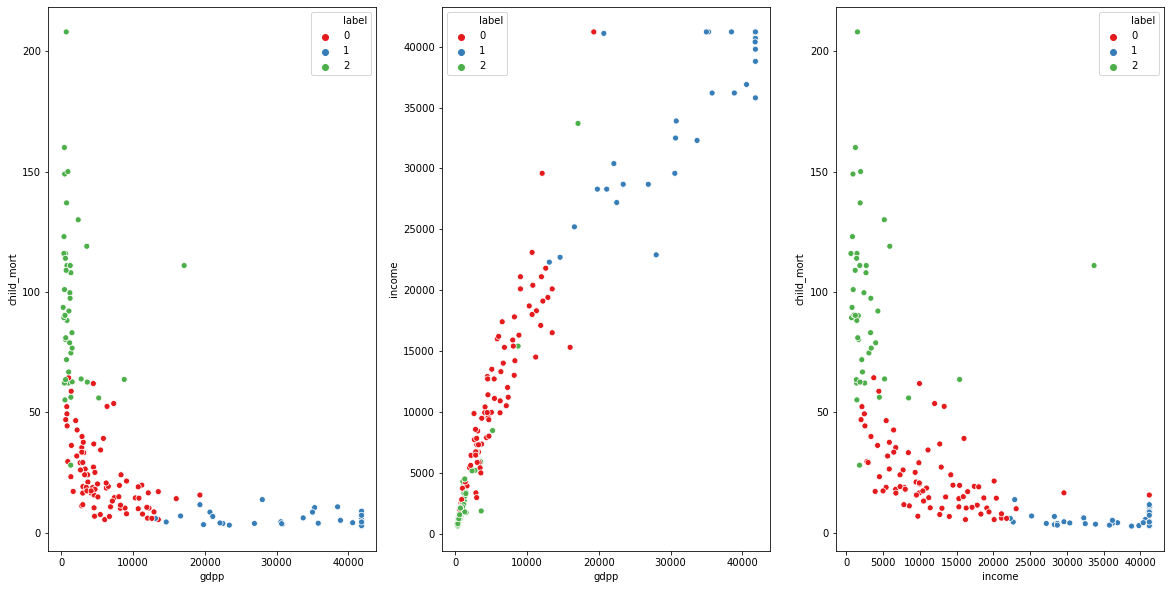

In [32]:
#We can use scatterplots to see how our data points have been assigned. 
plt.figure(figsize=(20,10))
plt.subplot(131)
sns.scatterplot(x='gdpp',y='child_mort',hue='label',data=df_km,palette='Set1')
plt.subplot(132)
sns.scatterplot(x='gdpp',y='income',hue='label',data=df_km,palette='Set1')
plt.subplot(133)
sns.scatterplot(x='income',y='child_mort',hue='label',data=df_km,palette='Set1')
plt.show()

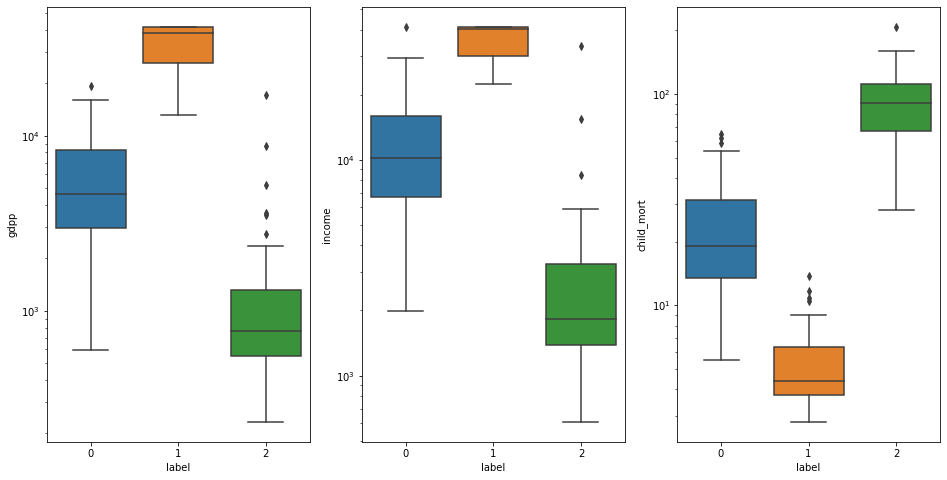

In [33]:
# We can visualize using boxplots for each feature
plt.figure(figsize=(16,8))
for i,each in enumerate(['gdpp','income','child_mort']):
    plt.subplot(1,3,i+1)
    ax=sns.boxplot(y=df_km[each],x=df_km.label)
    ax.set_yscale('log') #Using log scale to better visualize child mortality
plt.show()

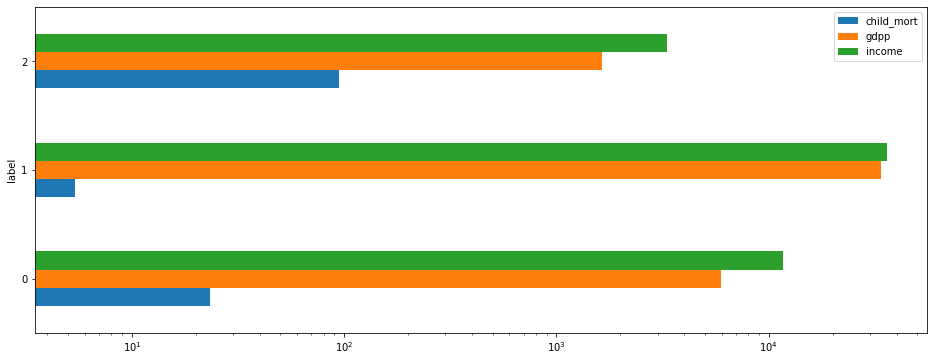

In [34]:
#Let's see how the mean of features, broken down by cluster
ax=df_km.drop(['country'],axis=1).groupby('label')['child_mort','gdpp','income'].mean().plot(kind='barh',figsize=(16,6))
ax.set_xscale('log') #using log scale to be able to see child_mort next to other features
plt.show()

We also conduct cluster profiling for our data set when clustered using k=4

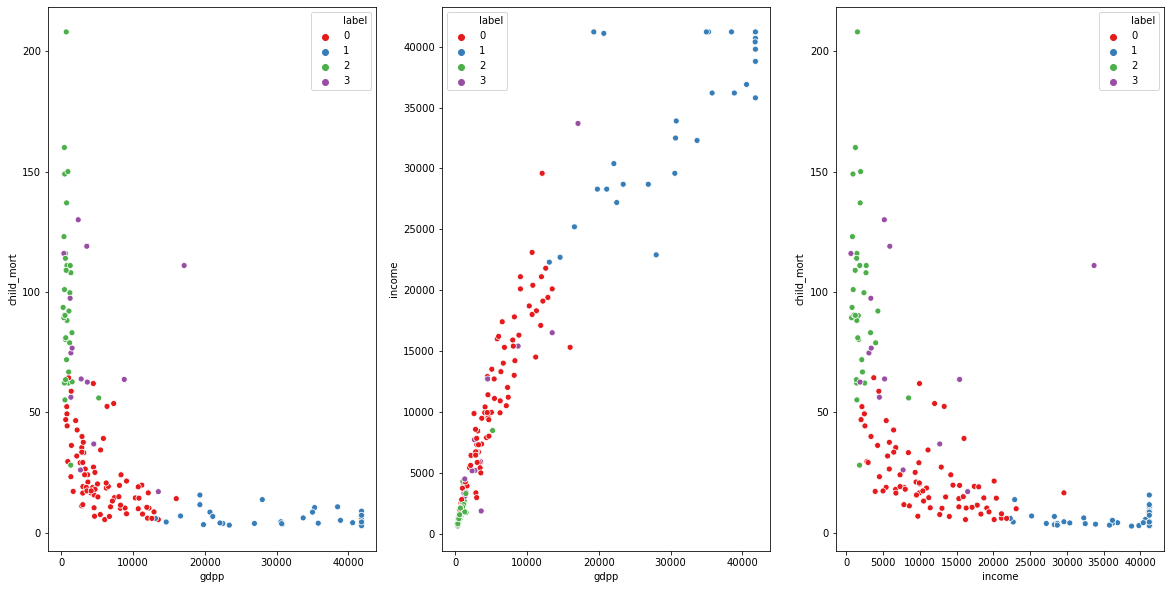

In [35]:
#We can use scatterplots to see how our data points have been assigned. 
plt.figure(figsize=(20,10))
plt.subplot(131)
sns.scatterplot(x='gdpp',y='child_mort',hue='label',data=df_km4,palette='Set1')
plt.subplot(132)
sns.scatterplot(x='gdpp',y='income',hue='label',data=df_km4,palette='Set1')
plt.subplot(133)
sns.scatterplot(x='income',y='child_mort',hue='label',data=df_km4,palette='Set1')
plt.show()

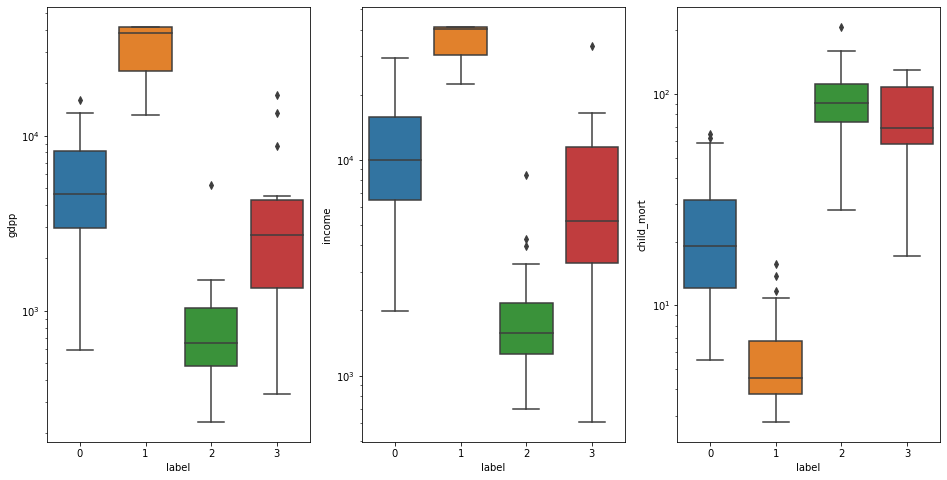

In [36]:
# We can visualize using boxplots for each feature
plt.figure(figsize=(16,8))
for i,each in enumerate(['gdpp','income','child_mort']):
    plt.subplot(1,3,i+1)
    ax=sns.boxplot(y=df_km4[each],x=df_km4.label)
    ax.set_yscale('log') #Using log scale to better visualize child mortality
plt.show()

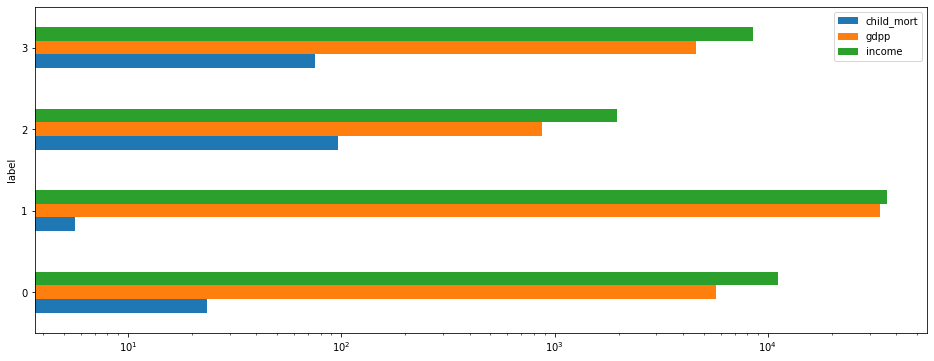

In [37]:
#Let's see how the mean of features, broken down by cluster
ax=df_km4.drop(['country'],axis=1).groupby('label')['child_mort','gdpp','income'].mean().plot(kind='barh',figsize=(16,6))
ax.set_xscale('log') #using log scale to be able to see child_mort next to other features
plt.show()

## Final decision for value of K
From the plots seen above, we observe that our target cluster can be set as the one with high value of child mortality and low GDP and income parameters. Thus, we can achieve the business objective promptly by using the value of k as 3. We can move forward with K set to 3. 

From what we can obseve during cluster profiling, we have the below three clusters: 
* Cluster 1
    * Contains data points with the highest income and GDPP, and lowest child mortality rates
* Cluster 2
    * Contains data points with lowest income and GDPP, and highest child mortality rates
    * This should our target cluster that needs to be reported to the business.
    
* Cluster 0
    * Contains data points with a medium level income and GDPP and moderately high child mortality rate

## Results from K-Means Clustering

In [38]:
#Now, let us filter the data on our target cluster and see the top 5 countries in direst need of financial support
#We will be using the sorting criteria as GDPP (ascending), Child Mortality (Descending) and Income (ascending) as the sort levels, in that order.
target_km = df_km[df_km['label']==2].sort_values(by=['gdpp','child_mort','income'], ascending=[True,False,True])

In [39]:
#Let's see what our top five countries are from K-Means clustering
target_km[:5]['country']

26              Burundi
88              Liberia
37     Congo, Dem. Rep.
112               Niger
132        Sierra Leone
Name: country, dtype: object

## Hierarchical Clustering
We now move on to building the clusters using hierarchical clustering algorithm. This will help us build more confidence in the clusters that we obtained using k-means clustering, and help boost business value.

In [40]:
#We will use the scaled dataset
df1.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291537,-0.797286,-0.676931,-0.841497,-0.994369,0.265002,-1.619705,1.926396,-0.786811
1,-0.538993,-0.611636,-0.490348,-0.493824,-0.386326,-0.372075,0.648831,-0.865054,-0.531304
2,-0.272870,-0.514980,-0.557986,-0.611211,-0.169272,1.122161,0.671403,-0.034983,-0.504576
3,2.007831,-0.432103,-0.628481,-0.588439,-0.680847,1.932987,-1.179541,2.153997,-0.571758
4,-0.695682,0.138833,-0.104136,0.545147,0.283837,-0.764618,0.705262,-0.543736,0.054549


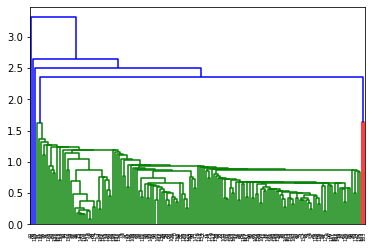

In [41]:
#We will first try to run the algorithm using single linkage
mergings = linkage(df1, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

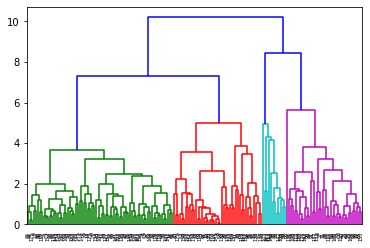

In [42]:
#Let's also take a look at results using complete linkage
mergings = linkage(df1, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [43]:
# We choose are cutting point to get 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )

In [44]:
#We create a copy of the oriignal DF, and add these labels to it. 
df_hc = df.copy()
df_hc['label']=cluster_labels
df_hc.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
0,Afghanistan,90.2,55.30,41.92,248.30,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.90,1987.74,9930.0,4.49,76.3,1.65,4090.0,1
2,Algeria,27.3,1712.64,185.98,1400.44,12900.0,16.10,76.5,2.89,4460.0,1
3,Angola,119.0,2199.19,100.60,1514.37,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100.0,1.44,76.8,2.13,12200.0,1


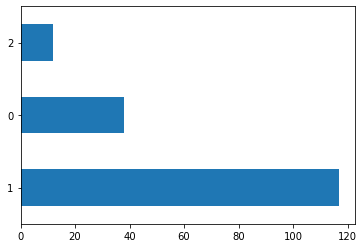

In [45]:
#Plotting the value counts for our clusters, and relating this with the dendrogram above, we can see that even if we had chosen 4 as the number of clusters, our target cluster (0) would remain unaffected. Since upon choosing 4, the cluster 1 (the biggest one) would just break up into two smaller ones, while our target cluster still remains the same (as explained in the cluster profiling section below)
df_hc.label.value_counts().plot.barh()

## Cluster profiling from the model built using hierarchical clustering

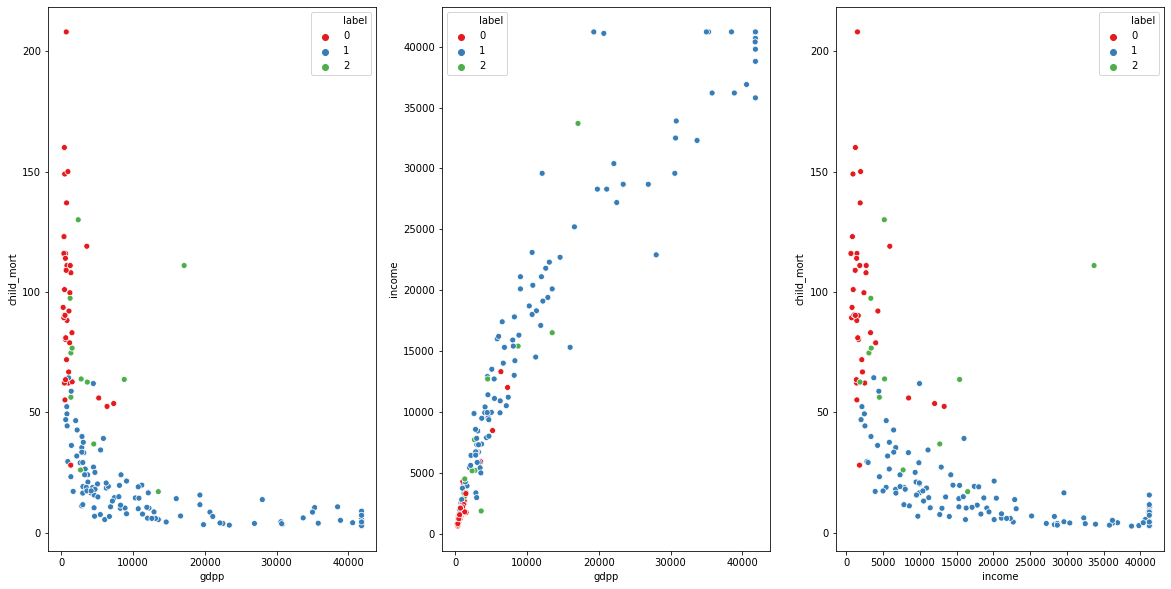

In [46]:
#We can use scatterplots to see how our data points have been assigned. 
plt.figure(figsize=(20,10))
plt.subplot(131)
sns.scatterplot(x='gdpp',y='child_mort',hue='label',data=df_hc,palette='Set1')
plt.subplot(132)
sns.scatterplot(x='gdpp',y='income',hue='label',data=df_hc,palette='Set1')
plt.subplot(133)
sns.scatterplot(x='income',y='child_mort',hue='label',data=df_hc,palette='Set1')
plt.show()

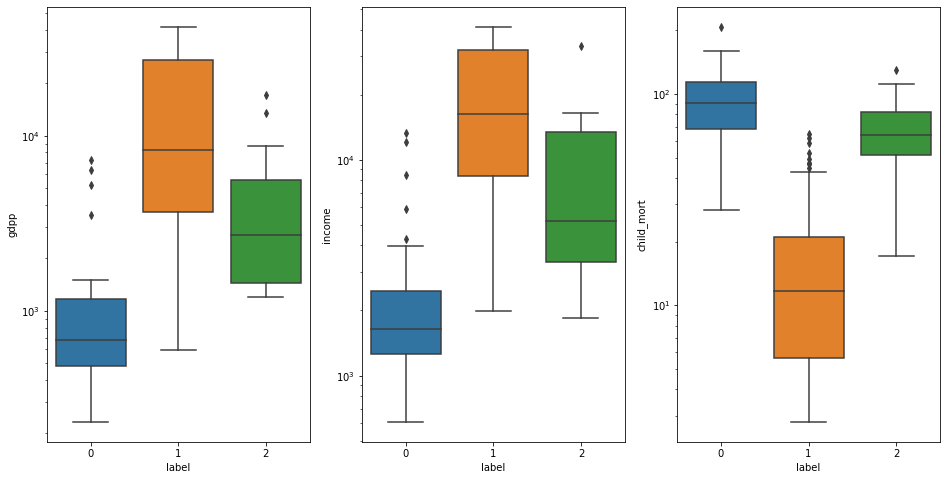

In [47]:
# We can visualize using boxplots for each feature
plt.figure(figsize=(16,8))
for i,each in enumerate(['gdpp','income','child_mort']):
    plt.subplot(1,3,i+1)
    ax=sns.boxplot(y=df_hc[each],x=df_hc.label)
    ax.set_yscale('log') #Using log scale to better visualize child mortality
plt.show()

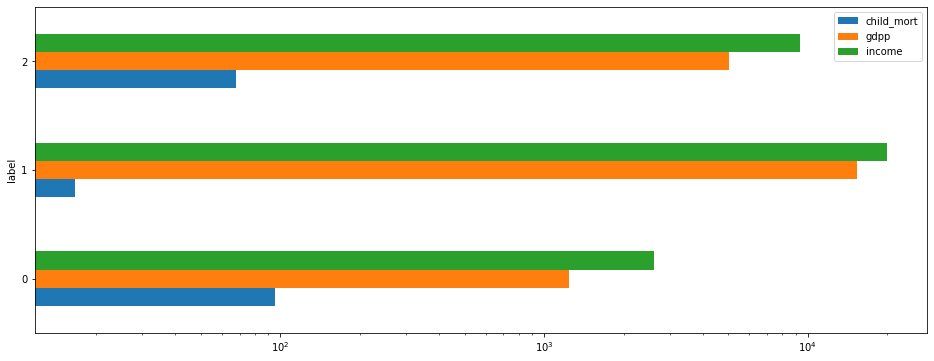

In [48]:
#Let's see how the mean of features, broken down by cluster
ax=df_hc.drop(['country'],axis=1).groupby('label')['child_mort','gdpp','income'].mean().plot(kind='barh',figsize=(16,6))
ax.set_xscale('log') #using log scale to be able to see child_mort next to other features
plt.show()

We see similar clusters here, as we saw in k-means. Our target cluster would be cluster 0, where the child mortality is high and income and GDPP are low. 

## Results from Hierarchical Clustering

In [49]:
#Now, let us filter the data on our target cluster and see the top 5 countries in direst need of financial support
#We will be using the sorting criteria as GDPP (ascending), Child Mortality (Descending) and Income (ascending) as the sort levels, in that order.
target_hc = df_hc[df_hc['label']==0].sort_values(by=['gdpp','child_mort','income'], ascending=[True,False,True])

In [50]:
#We now observe that the list of countries we get from hierarchical clustering is exactly the same as we had obtained from K-means. 
#Hence, we can present these findings to the CEO with a fair amount of confidence and evidence to back our deductions.
target_hc[:5]['country']

26              Burundi
88              Liberia
37     Congo, Dem. Rep.
112               Niger
132        Sierra Leone
Name: country, dtype: object